<a href="https://colab.research.google.com/github/agalvezm/ACE2_scRNAseq/blob/master/notebooks_countmatrices/GSE114530_GSM3143601_GSM3509839.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GSE : GSM

In [1]:
# Accession id for the data
database_id = "GSE114530"
species = "human"
name_SRA_table = "GSM3143601_GSM3509839.txt"

# Clone, import and install software

In [2]:
# Clone repository for sradownloader
!git clone https://github.com/s-andrews/sradownloader.git


# install and import necessary software

# Install kb and scanpy
!pip -q install kb-python 
!pip -q install scanpy

import re
import os

# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

Cloning into 'sradownloader'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 134 (delta 66), reused 87 (delta 32), pack-reused 0
Receiving objects: 100% (134/134), 172.50 KiB | 466.00 KiB/s, done.
Resolving deltas: 100% (66/66), done.
     |████████████████████████████████| 35.4MB 116kB/s 
     |████████████████████████████████| 122kB 53.5MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 112kB 50.5MB/s 
     |████████████████████████████████| 7.7MB 2.7MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 


# Download data and reference

SRA table downloaded from: 

In [3]:
!./sradownloader/sradownloader --outdir fastqs $name_SRA_table

Testing for fasterq-dump at fasterq-dump
Testing for gzip in the path
Found gzip
Reading samples from GSM3143601_GSM3509839.txt
Trying to get name for SRR8313168 from GEO
Found sample SRR8313168 with basename SRR8313168_GSM3509839_Week_13_fetal_kidney_Homo_sapiens_RNA-Seq
Trying to get name for SRR8313172 from GEO
Found sample SRR8313172 with basename SRR8313172_GSM3509839_Week_13_fetal_kidney_Homo_sapiens_RNA-Seq
Trying to get name for SRR8313173 from GEO
Found sample SRR8313173 with basename SRR8313173_GSM3509839_Week_13_fetal_kidney_Homo_sapiens_RNA-Seq
Trying to get name for SRR7171581 from GEO
Found sample SRR7171581 with basename SRR7171581_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq
Trying to get name for SRR7171582 from GEO
Found sample SRR7171582 with basename SRR7171582_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq
Trying to get name for SRR7171583 from GEO
Found sample SRR7171583 with basename SRR7171583_GSM3143601_w16_human_embryonic_kidney_Homo_

In [4]:
# Download the corresponding Kallisto index to content folder
!kb ref -d $species -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2020-10-05 20:00:42,633]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
[2020-10-05 20:03:14,260]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


# Metadata

In [16]:
number_of_samples = 2

fastqs_per_sample = [8, 16]

sample_id = ["GSM3143601", "GSM3509839"]

tissue = ["kidney"] * number_of_samples

cell_type = ["embrionic kidney"] * number_of_samples

condition = ["week 16", "week 13"] 

technology = ["10xv2"] * number_of_samples

paper = ["Muus et al 2020"] * number_of_samples

figure = ["Fig 1 a,b  ED Fig 1 a,b,c,d  ED Fig 2 a,b,c,d,e"] * number_of_samples

# Filters for analysis

cell_threshold = 100

gene_threshold = 3

# Set string variables for kb functions

species_kb = species

technology_kb = technology[0]

In [17]:
# Check that you have the right amount of files

files = !ls /content/fastqs | wc -l
int(files[0])  == np.sum(fastqs_per_sample)

True

In [18]:
# Store filenames in fastqs variable
fastqs = !ls /content/fastqs

In [19]:
# Check variable
fastqs

['SRR7171580_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_1.fastq.gz',
 'SRR7171580_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_2.fastq.gz',
 'SRR7171581_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_1.fastq.gz',
 'SRR7171581_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_2.fastq.gz',
 'SRR7171582_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_1.fastq.gz',
 'SRR7171582_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_2.fastq.gz',
 'SRR7171583_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_1.fastq.gz',
 'SRR7171583_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_2.fastq.gz',
 'SRR8313167_GSM3509839_Week_13_fetal_kidney_Homo_sapiens_RNA-Seq_1.fastq.gz',
 'SRR8313167_GSM3509839_Week_13_fetal_kidney_Homo_sapiens_RNA-Seq_2.fastq.gz',
 'SRR8313168_GSM3509839_Week_13_fetal_kidney_Homo_sapiens_RNA-Seq_1.fastq.gz',
 'SRR8313168_GSM3509839_Week_13_fetal_kidney_Homo_sapiens_RNA-Seq_2.fastq.gz',
 'SR

# Run kb

In [22]:
%cd /content/fastqs

/content/fastqs


In [23]:
# Run kb

if number_of_samples == 1:

  # Write the kb count command as a string with all fastqs of the list as an input
  cmd = "kb count --h5ad -i ../index.idx -g ../t2g.txt -x " + technology_kb + " -o output" + sample_id[0] + " "\
  + "--filter bustools -t 2 --overwrite " + "'" +  "' '".join(fastqs) + "'"
  
  # Execute it
  !$cmd


# If more than one sample, iterate through fastqs accordingly
else:

  # Initializa counter for fastq files
  j = 0

  # Loop over samples for analysis
  for i in range(number_of_samples):

    fastqs_to_analyze = fastqs[j:j + fastqs_per_sample[i]]
    # Write the kb count command as a string
    cmd = "kb count --h5ad -i ../index.idx -g ../t2g.txt -x " + technology_kb + " -o output" + sample_id[i] + " \
    --filter bustools -t 2 --overwrite " + "'" +  "' '".join(fastqs_to_analyze) + "'"

    # Execute it
    !$cmd

    # Update j to move to the next set of fastq
    j = j + fastqs_per_sample[i]





[2020-10-05 21:32:23,151]    INFO Generating BUS file from
[2020-10-05 21:32:23,152]    INFO         SRR7171580_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_1.fastq.gz
[2020-10-05 21:32:23,152]    INFO         SRR7171580_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_2.fastq.gz
[2020-10-05 21:32:23,152]    INFO         SRR7171581_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_1.fastq.gz
[2020-10-05 21:32:23,152]    INFO         SRR7171581_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_2.fastq.gz
[2020-10-05 21:32:23,152]    INFO         SRR7171582_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_1.fastq.gz
[2020-10-05 21:32:23,152]    INFO         SRR7171582_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_2.fastq.gz
[2020-10-05 21:32:23,152]    INFO         SRR7171583_GSM3143601_w16_human_embryonic_kidney_Homo_sapiens_RNA-Seq_1.fastq.gz
[2020-10-05 21:32:23,152]    INFO         SRR7171583_GSM3143601_w16_human_embryo

# Load unfiltered matrices

In [24]:
# Define dict to store data
results = {}

In [25]:
# load the unfiltered matrix

t2g = pd.read_csv("../t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

for i in range(number_of_samples):
  results[sample_id[i]] = anndata.read_h5ad("output" + sample_id[i] + "/counts_unfiltered/adata.h5ad")
  results[sample_id[i]].var["gene_id"] = results[sample_id[i]].var.index.values

  results[sample_id[i]].var["gene_name"] = results[sample_id[i]].var.gene_id.map(t2g["gene_name"])
  results[sample_id[i]].var.index = results[sample_id[i]].var["gene_name"]
  print("The unfiltered matrix " + sample_id[i] + " contains {} cells by {} genes".format(len(results[sample_id[i]].obs), len(results[sample_id[i]].var)))

  results[sample_id[i]].obs["cell_counts"] = results[sample_id[i]].X.sum(axis=1)
  results[sample_id[i]].var["gene_counts"] = nd(results[sample_id[i]].X.sum(axis=0))

  results[sample_id[i]].obs["n_genes"] = nd((results[sample_id[i]].X>0).sum(axis=1))
  results[sample_id[i]].var["n_cells"] = nd((results[sample_id[i]].X>0).sum(axis=0))

  mito_genes = results[sample_id[i]].var_names.str.startswith("MT-" or "mt-") 
  results[sample_id[i]].obs["percent_mito"] = results[sample_id[i]][:,mito_genes].X.sum(axis=1)/results[sample_id[i]].X.sum(axis=1)*100

  # Changing the name of the index is necessary to write the file (it won't work with duplicated names)
  results[sample_id[i]].var.index.name = "index"



The unfiltered matrix GSM3143601 contains 373711 cells by 60623 genes
The unfiltered matrix GSM3509839 contains 361098 cells by 60623 genes


# Assign filter to each sample individually

In [35]:
# Change sample number manually
samp_n = 1

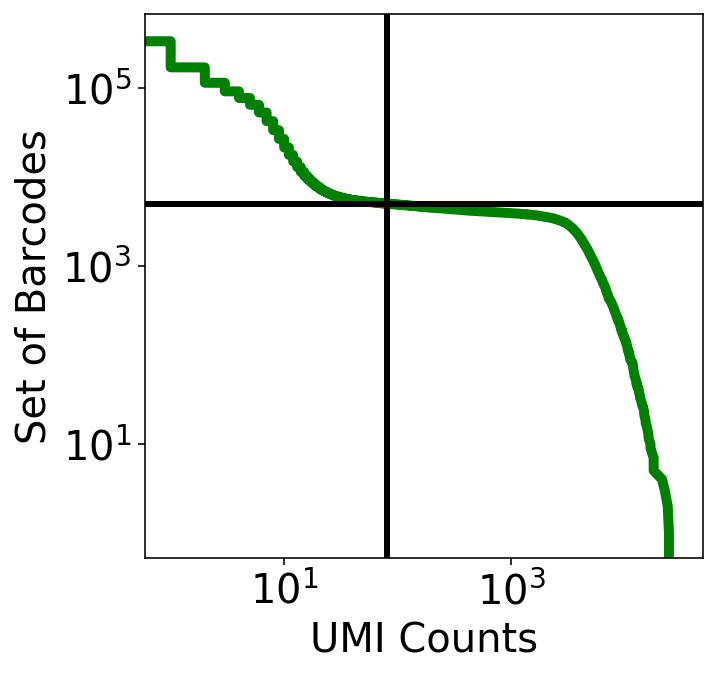

Cells were filtered down to 5000 with at least 81.0 UMIs


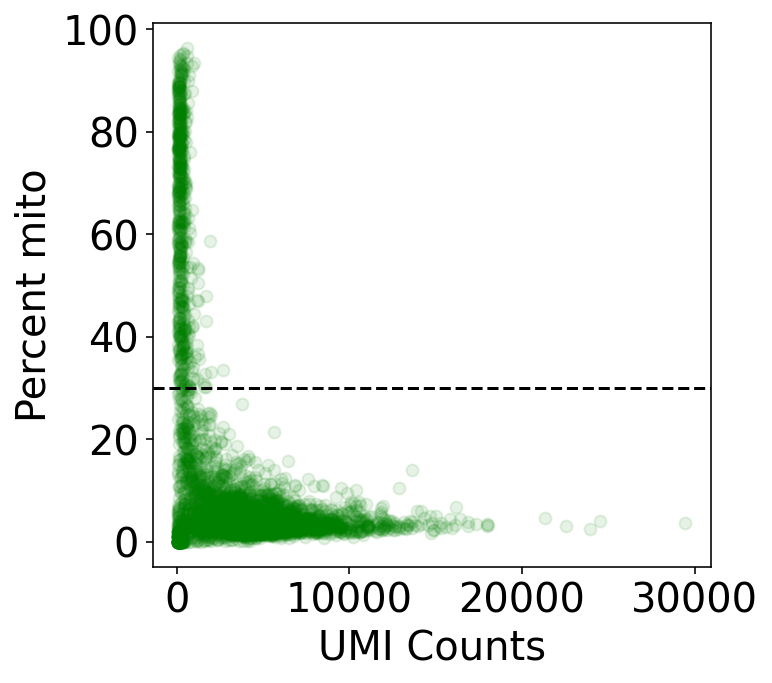

We select 30 % as the mitochondrial content threshold


In [41]:

expected_num_cells = 5000#@param {type:"integer"}
knee = np.sort(nd(results[sample_id[samp_n]].X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

cell_threshold = knee[expected_num_cells]

results["cell_threshold" + sample_id[samp_n]] = knee[expected_num_cells]

print ("Cells were filtered down to " + str(expected_num_cells) + " with at least " + str(cell_threshold) + " UMIs")


mito_criteria = 30#@param {type:"integer"}
results["mito_criteria" + sample_id[samp_n]] = mito_criteria

fig, ax = plt.subplots(figsize=(5,5))


x = nd(results[sample_id[i]].obs["cell_counts"][results[sample_id[i]].obs["cell_counts"] > cell_threshold])
y = nd(results[sample_id[i]].obs["percent_mito"][results[sample_id[i]].obs["cell_counts"] > cell_threshold])

ax.scatter(x, y, color="green", alpha=0.1)

ax.axhline(y=mito_criteria, linestyle="--", color="k")


ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")


plt.show()

print("We select " + str(mito_criteria) + " % as the mitochondrial content threshold")

# Filter matrix

In [42]:
for i in range(number_of_samples):
  results[sample_id[i]].obs["pass_count_filter"] = results[sample_id[i]].obs["cell_counts"] > results["cell_threshold" + sample_id[i]]
  results[sample_id[i]].obs["pass_mito_filter"] = results[sample_id[i]].obs.percent_mito < results["mito_criteria" + sample_id[i]]
  results[sample_id[i]].var["pass_gene_filter"] = results[sample_id[i]].var["n_cells"] > gene_threshold

  cell_mask = np.logical_and(results[sample_id[i]].obs["pass_count_filter"].values, results[sample_id[i]].obs["pass_mito_filter"].values)
  gene_mask = results[sample_id[i]].var["pass_gene_filter"].values

  print("Current Shape: {:,} cells x {:,} genes".format(results[sample_id[i]].shape[0], results[sample_id[i]].shape[1]))
  print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))
  results["data_" + sample_id[i]] = results[sample_id[i]][cell_mask, gene_mask]

Current Shape: 373,711 cells x 60,623 genes
    New shape: 11,806 cells x 32,707 genes
Current Shape: 361,098 cells x 60,623 genes
    New shape: 4,416 cells x 28,567 genes


# Annotate and write Anndata object

In [43]:
for i in range(number_of_samples):


  results["data_" + sample_id[i]].uns["database_id"] = database_id

  results["data_" + sample_id[i]].uns["tissue"] = tissue[samp_n]

  results["data_" + sample_id[i]].uns["cell_type"] = cell_type[samp_n]

  results["data_" + sample_id[i]].uns["sample_id"] = sample_id[samp_n]

  results["data_" + sample_id[i]].uns["condition"] = condition[samp_n]

  results["data_" + sample_id[i]].uns["species"] = species

  results["data_" + sample_id[i]].uns["technology"] = technology[samp_n]

  results["data_" + sample_id[i]].uns["paper"] = paper[samp_n]

  results["data_" + sample_id[i]].uns["figure"] = figure[samp_n]

# Write anndata object

%cd /content

for i in range(number_of_samples):

  results["data_" + sample_id[i]].write("result" + sample_id[i])

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/content


... storing 'gene_name' as categorical
... storing 'gene_name' as categorical
